In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
from sklearn.metrics import accuracy_score
from torchvision.models import densenet121
import torchvision.models as models
# from vit_pytorch import ViT
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import logging
import matplotlib.pyplot as plt


c:\Users\dines\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Define your dataset class
class SpoofingDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0][2:].replace('\\', '/'))
        image = Image.open(img_name).convert("RGB")
        label = self.data.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define data augmentation transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset
root_dir = '/kaggle/input/replay-dataset/'
train_dataset = SpoofingDataset(csv_file=os.path.join('/kaggle/input/replay-csv', 'train_data.csv'), root_dir=root_dir, transform=transform)
val_dataset = SpoofingDataset(csv_file=os.path.join('/kaggle/input/replay-csv/', 'test_data.csv'), root_dir=root_dir, transform=transform)

# Define data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the ViT model with DenseNet backbone
class ViT_DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(ViT_DenseNet, self).__init__()
        # Load the pre-trained DenseNet
        self.densenet = models.densenet121(pretrained=True)
        
        # Remove the classification layer of DenseNet
        self.densenet = nn.Sequential(*list(self.densenet.children())[:-1])
        self.reduce_channels = nn.Conv2d(in_channels=1024, out_channels=3, kernel_size=1)
        # Create the ViT model
        self.vit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        # Separate branch for binary supervision loss calculation
        self.supervision_branch = nn.Conv2d(1024, 1, kernel_size=1)
        
        self.fc = nn.Linear(1000, num_classes)  # Output layer for binary classification

    def forward(self, x):
        densenet_output = self.densenet(x)

        supervision_output = self.supervision_branch(densenet_output)  # For supervision loss
        # print('supervision_output', supervision_output.shape)

        resized_output = F.interpolate(densenet_output, scale_factor=32, mode='bilinear', align_corners=False)
        # print('resized_output', resized_output.shape)
        reduced_output = self.reduce_channels(resized_output)
        # print('reduced_output', reduced_output.shape)
        
        vit_output = self.vit(reduced_output)  # For classification
        # print('vit_output', vit_output.shape)

        final_output = self.fc(vit_output)
        # print('final_output', final_output.shape)
        
        return supervision_output, final_output

# Define the model, loss functions, and optimizer
model = ViT_DenseNet(num_classes=1)  # 1 output for binary classification
# mse_criterion = nn.MSELoss()  # Mean Squared Error loss
bce_criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)

logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


for epoch in range(num_epochs):
    model.train()
    train_losses_bcep = []
    train_losses_bce = []
    total_training_loss = []
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass through the model
        supervision_output, final_output = model(images)
        
        # Calculate the binary supervision loss using MSE
        batch_size = labels.size(0)
        # Repeat labels tensor over the dimensions of supervision_output
        supervision_labels = labels.view(batch_size, 1, 1, 1).repeat(1, 1, 7, 7)
        
        supervision_loss = bce_criterion(supervision_output.view(-1), supervision_labels.view(-1).float())
        
        # Calculate the binary cross-entropy loss using BCE

        # Create the target tensor with the same shape as final_output
        # Reshape labels to have shape [batch_size, 1]
        labels = labels.unsqueeze(1)
        
        # Create final_labels tensor
        final_labels = torch.ones_like(final_output) * labels  # Broadcasting to match final_output shape

        cross_entropy_loss = bce_criterion(final_output.view(-1), final_labels.view(-1).float())
        
        # Calculate the total loss
        theta = 0.3  # Adjust as needed
        total_loss = (1 - theta) * cross_entropy_loss + theta * supervision_loss
        
        total_loss.backward()
        optimizer.step()
        train_losses_bcep.append(supervision_loss.item())
        train_losses_bce.append(cross_entropy_loss.item())
        total_training_loss.append(total_loss.item())
    
    model.eval()
    val_losses_bcep = []
    val_losses_bce = []
    total_val_loss = []
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            supervision_output, final_output = model(images)
            batch_size = labels.size(0)
            # Repeat labels tensor over the dimensions of supervision_output
            supervision_labels = labels.view(batch_size, 1, 1, 1).repeat(1, 1, 7, 7)
            # Calculate the MSE loss for validation
            supervision_loss = bce_criterion(supervision_output.view(-1), supervision_labels.view(-1).float())
            val_losses_bcep.append(supervision_loss.item())
            
            # Calculate the BCE loss for validation
            labels = labels.unsqueeze(1)

            # Create final_labels tensor
            final_labels = torch.ones_like(final_output) * labels  # Broadcasting to match final_output shape

            cross_entropy_loss = bce_criterion(final_output.view(-1), final_labels.view(-1).float())
            val_losses_bce.append(cross_entropy_loss.item())

            theta = 0.3  # Adjust as needed
            total_valid_loss = (1 - theta) * cross_entropy_loss + theta * supervision_loss
            total_val_loss.append(total_valid_loss.item())

            val_predictions.extend(torch.sigmoid(final_output).cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    # Calculate validation accuracy
    val_predictions = [1 if x >= 0.5 else 0 for x in val_predictions]
    val_accuracy = accuracy_score(val_true_labels, val_predictions)

    # Save the model checkpoint
    checkpoint_path = f'model_exp3_checkpoint_epoch_{epoch+1}.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses_bcep': train_losses_bcep,
        'train_losses_bce': train_losses_bce,
        'total_training_loss': total_training_loss,
        'val_losses_bcep': val_losses_bcep,
        'val_losses_bce': val_losses_bce,
        'total_val_loss': total_val_loss,
        'val_predictions': val_predictions,
        'val_true_labels': val_true_labels,
        'val_accuracy': val_accuracy
    }, checkpoint_path)
    logging.info(f"Model checkpoint saved at: {checkpoint_path}") 
    
    # Log the values
    logging.info(f"Epoch [{epoch+1}/{num_epochs}]")
    logging.info(f"Training BCE supervision Loss: {sum(train_losses_bcep) / len(train_losses_bcep):.4f}")
    logging.info(f"Training BCE classification Loss: {sum(train_losses_bce) / len(train_losses_bce):.4f}")
    logging.info(f"Training Total Loss: {sum(total_training_loss) / len(total_training_loss):.4f}")
    logging.info(f"Validation BCE supervision Loss: {sum(val_losses_bcep) / len(val_losses_bcep):.4f}")
    logging.info(f"Validation BCE classification Loss: {sum(val_losses_bce) / len(val_losses_bce):.4f}")
    logging.info(f"Validation Total Loss: {sum(total_val_loss) / len(total_val_loss):.4f}")
    logging.info(f"Validation Accuracy: {val_accuracy:.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training BCE supervision Loss: {sum(train_losses_bcep) / len(train_losses_bcep):.4f}")
    print(f"Training BCE classification Loss: {sum(train_losses_bce) / len(train_losses_bce):.4f}")
    print(f"Validation BCE supervision Loss: {sum(val_losses_bcep) / len(val_losses_bcep):.4f}")
    print(f"Validation BCE classification Loss: {sum(val_losses_bce) / len(val_losses_bce):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 189MB/s]
Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2

Epoch [1/5]
Training BCE supervision Loss: 0.0901
Training BCE classification Loss: 0.0678
Validation BCE supervision Loss: 0.0164
Validation BCE classification Loss: 0.0038
Validation Accuracy: 0.9995


100%|██████████| 625/625 [02:30<00:00,  4.15it/s]


Epoch [2/5]
Training BCE supervision Loss: 0.0235
Training BCE classification Loss: 0.0087
Validation BCE supervision Loss: 0.0380
Validation BCE classification Loss: 0.0398
Validation Accuracy: 0.9860


100%|██████████| 625/625 [02:32<00:00,  4.09it/s]


Epoch [3/5]
Training BCE supervision Loss: 0.0121
Training BCE classification Loss: 0.0025
Validation BCE supervision Loss: 0.0051
Validation BCE classification Loss: 0.0016
Validation Accuracy: 0.9993


100%|██████████| 625/625 [03:03<00:00,  3.41it/s]


Epoch [4/5]
Training BCE supervision Loss: 0.0296
Training BCE classification Loss: 0.0142
Validation BCE supervision Loss: 0.0110
Validation BCE classification Loss: 0.0319
Validation Accuracy: 0.9936


100%|██████████| 625/625 [02:31<00:00,  4.14it/s]


Epoch [5/5]
Training BCE supervision Loss: 0.0153
Training BCE classification Loss: 0.0111
Validation BCE supervision Loss: 0.0045
Validation BCE classification Loss: 0.0015
Validation Accuracy: 1.0000


In [3]:
# Save the model
saved_model_path = 'densenet_vit_exp3.pth'
torch.save(model.state_dict(), saved_model_path)
print(f"Model saved at {saved_model_path}")

Model saved at densenet_vit_exp3.pth


In [4]:
log_file = './exp3_training_log.txt'

epochs = []
train_bcep_losses = []
train_bce_losses = []
train_total_losses = []
val_bcep_losses = []
val_bce_losses = []
val_total_losses = []
val_accuracies = []

with open(log_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'Epoch' in line:
            epochs.append(int(line.split('/')[0].split('[')[1]))
        elif 'Training BCE supervision Loss' in line:
            train_bcep_losses.append(float(line.split(': ')[1]))
        elif 'Training BCE classification Loss' in line:
            train_bce_losses.append(float(line.split(': ')[1]))
        # elif 'Training Total Loss' in line:
        #     train_total_losses.append(float(line.split(': ')[1]))
        elif 'Validation BCE supervision Loss' in line:
            val_bcep_losses.append(float(line.split(': ')[1]))
        elif 'Validation BCE classification Loss' in line:
            val_bce_losses.append(float(line.split(': ')[1]))
        # elif 'Validation Total Loss' in line:
        #     val_total_losses.append(float(line.split(': ')[1]))
        elif 'Validation Accuracy' in line:
            val_accuracies.append(float(line.split(': ')[1]))

# Now you have the extracted information, you can use it to create plots


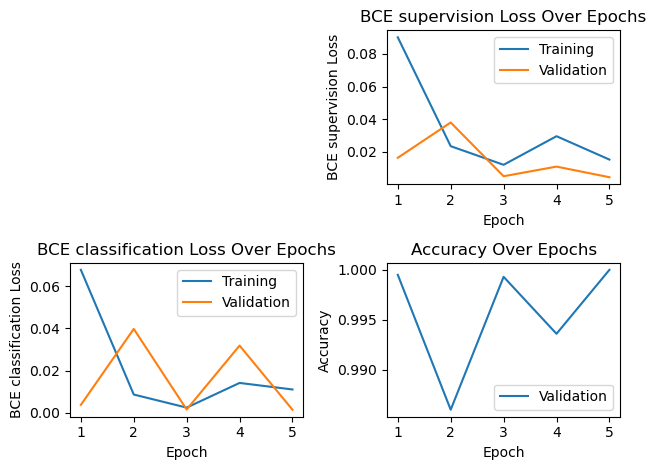

In [5]:
# Plot total loss
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 2, 1)
# plt.plot(epochs, train_total_losses, label='Training')
# plt.plot(epochs, val_total_losses, label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Total Loss')
# plt.title('Total Loss Over Epochs')
# plt.legend()

# Plot MSE loss
plt.subplot(2, 2, 2)
plt.plot(epochs, train_bcep_losses, label='Training')
plt.plot(epochs, val_bcep_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('BCE supervision Loss')
plt.title('BCE supervision Loss Over Epochs')
plt.legend()

# Plot BCE loss
plt.subplot(2, 2, 3)
plt.plot(epochs, train_bce_losses, label='Training')
plt.plot(epochs, val_bce_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('BCE classification Loss')
plt.title('BCE classification Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()